In [12]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras

In [18]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [14]:
# Read in the csv data using pandas 
train  = pd.read_csv('santander-customer-satisfaction/train.csv',index_col=0)
test   = pd.read_csv('santander-customer-satisfaction/test.csv', index_col=0)
sample = pd.read_csv('santander-customer-satisfaction/sample_submission.csv')

In [15]:
train.dtypes.value_counts()

int64      259
float64    111
Name: count, dtype: int64

In [19]:
train.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte

In [20]:
train.select_dtypes(include=['int64']).nunique()

var3                             208
var15                            100
ind_var1_0                         2
ind_var1                           2
ind_var2_0                         1
ind_var2                           1
ind_var5_0                         2
ind_var5                           2
ind_var6_0                         2
ind_var6                           2
ind_var8_0                         2
ind_var8                           2
ind_var12_0                        2
ind_var12                          2
ind_var13_0                        2
ind_var13_corto_0                  2
ind_var13_corto                    2
ind_var13_largo_0                  2
ind_var13_largo                    2
ind_var13_medio_0                  2
ind_var13_medio                    2
ind_var13                          2
ind_var14_0                        2
ind_var14                          2
ind_var17_0                        2
ind_var17                          2
ind_var18_0                        2
i

In [21]:
features_to_drop = train.nunique()
features_to_drop = features_to_drop.loc[features_to_drop.values==1].index

# now drop these columns from both the training and the test datasets
train = train.drop(features_to_drop,axis=1)
test  = test.drop(features_to_drop,axis=1)

In [22]:
train.isnull().values.any()

False

In [23]:
X = train.iloc[:,:-1]
y = train['TARGET']

In [24]:
y.value_counts().to_frame().T

TARGET,0,1
count,73012,3008


In [26]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [27]:
y_resampled.value_counts().to_frame().T

TARGET,0,1
count,73012,73012


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, 
    y_resampled, 
    train_size=0.5,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler  = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
test    = scaler.transform(test)

In [30]:
model = keras.Sequential(
    [
        keras.layers.Dense(units=9, activation="relu", input_shape=(X_train.shape[-1],) ),
        # randomly delete 30% of the input units below
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units=9, activation="relu"),
        # the output layer, with a single neuron
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

# save the initial weights for later
initial_weights = model.get_weights()

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 3024      
                                                                 
 dropout (Dropout)           (None, 9)                 0         
                                                                 
 dense_1 (Dense)             (None, 9)                 90        
                                                                 
 dense_2 (Dense)             (None, 1)                 10        
                                                                 
Total params: 3124 (12.20 KB)
Trainable params: 3124 (12.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
learning_rate = 0.001

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
    loss="binary_crossentropy", 
    metrics=keras.metrics.AUC()
)

In [36]:
history = model.fit(
    X_train, y_train, 
    epochs=500, 
    batch_size=1000, 
    validation_data=(X_val, y_val),
    verbose=0
)

2023-11-24 08:48:38.664916: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 97836080 exceeds 10% of free system memory.


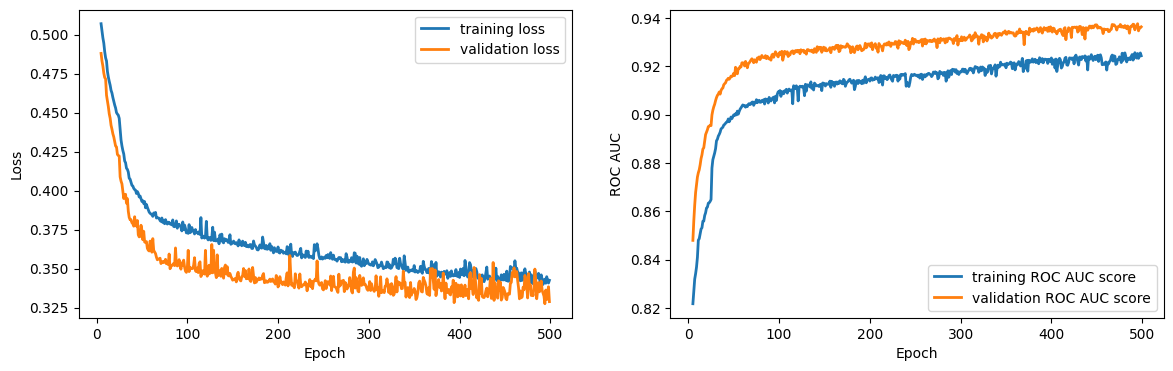

In [37]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc"], lw=2, label='training ROC AUC score')
plt.plot(logs.loc[5:,"val_auc"], lw=2, label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.show()

In [38]:
sample['TARGET'] = model.predict(test)

2023-11-24 08:54:00.816063: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 101596120 exceeds 10% of free system memory.


2370/2370 [==============================] - 5s 2ms/step


In [40]:
sample['TARGET']

0    0.453449
1    0.426770
2    0.022412
3    0.292103
4    0.064388
Name: TARGET, dtype: float32

In [45]:
# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

Saved model to disk
